In [1]:
import torch
from torchvision.datasets import MNIST
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import pickle
import base64
import sys

import hashlib
import json
from time import time
from time import sleep
import requests

%matplotlib inline
plt.rcParams['figure.figsize'] = [5, 5]

In [2]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 4.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [3]:
from torch import tensor
from torchmetrics.classification import MulticlassRecall
from torchmetrics.classification import MulticlassPrecision

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
with open('/content/gdrive/MyDrive/Colab Notebooks/BC+FL Code/datasets/train_set.pickle', 'rb') as fp:
  train_dataset = pickle.load(fp)

with open('/content/gdrive/MyDrive/Colab Notebooks/BC+FL Code/datasets/test_set.pickle', 'rb') as fp:
  test_dataset = pickle.load(fp)

with open('/content/gdrive/MyDrive/Colab Notebooks/BC+FL Code/datasets/dev_set.pickle', 'rb') as fp:
  dev_dataset = pickle.load(fp)

In [6]:
# MAKE SURE SAME FOR BOTH SERVER AND CLIENT CODE
classes = 10
input_dim = 784

batch_size = 128
epochs_per_client = 3
learning_rate = 2e-2

In [7]:
# CONFIGURE BEFORE RUNNIG
# MAKE SURE SAME FOR BOTH SERVER AND ALL CLIENTS' CODE
num_clients = 2
rounds = 2

In [8]:
# Make sure there is no '/' at the end of the url.
replit_url = "https://8e7399ac-6fda-47b4-9b7b-e7a2ed8d5bf1-00-1vdkonhfb818n.riker.replit.dev"

CHAIN_URL = f'{replit_url}/chain'
MINE_URL = f'{replit_url}/mine'
SEND_TRNS_URL = f'{replit_url}/transactions/new'
GET_TRNS_URL = f'{replit_url}/current'
PREV_BLK_URL = f'{replit_url}/last'

In [9]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            for batch in self.dl:
                yield to_device(batch, self.device)

        def __len__(self):
            return len(self.dl)

device = get_device()

In [10]:
class FederatedNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 20, 7)
        self.conv2 = torch.nn.Conv2d(20, 40, 7)
        self.maxpool = torch.nn.MaxPool2d(2, 2)
        self.flatten = torch.nn.Flatten()
        self.linear = torch.nn.Linear(2560, 10)
        self.non_linearity = torch.nn.functional.relu
        self.track_layers = {'conv1': self.conv1, 'conv2': self.conv2, 'linear': self.linear}

    def forward(self, x_batch):
        out = self.conv1(x_batch)
        out = self.non_linearity(out)
        out = self.conv2(out)
        out = self.non_linearity(out)
        out = self.maxpool(out)
        out = self.flatten(out)
        out = self.linear(out)
        return out

    def get_track_layers(self):
        return self.track_layers

    def apply_parameters(self, parameters_dict):
        with torch.no_grad():
            for layer_name in parameters_dict:
                self.track_layers[layer_name].weight.data *= 0
                self.track_layers[layer_name].bias.data *= 0
                self.track_layers[layer_name].weight.data += parameters_dict[layer_name]['weight']
                self.track_layers[layer_name].bias.data += parameters_dict[layer_name]['bias']

    def get_parameters(self):
        parameters_dict = dict()
        for layer_name in self.track_layers:
            parameters_dict[layer_name] = {
                'weight': self.track_layers[layer_name].weight.data,
                'bias': self.track_layers[layer_name].bias.data
            }
        return parameters_dict

    def batch_accuracy(self, outputs, labels):
        with torch.no_grad():
            _, predictions = torch.max(outputs, dim=1)
            return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))

    def _process_batch(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        accuracy = self.batch_accuracy(outputs, labels)
        precision = MulticlassPrecision(num_classes=10)
        precision_score = precision(outputs, labels)
        recall = MulticlassRecall(num_classes=10)
        recall_score = recall(outputs, labels)
        return (loss, accuracy, precision_score, recall_score)

    def fit(self, dataset, epochs, lr, batch_size=128, opt=torch.optim.SGD):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size, shuffle=True), device)
        optimizer = opt(self.parameters(), lr)
        history = []
        for epoch in range(epochs):
            losses = []
            accs = []
            prec_list = []
            rec_list = []
            for batch in dataloader:
                loss, acc, prec, rec = self._process_batch(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                loss.detach()
                losses.append(loss)
                accs.append(acc)
                prec_list.append(prec)
                rec_list.append(rec)
            avg_loss = torch.stack(losses).mean().item()
            avg_acc = torch.stack(accs).mean().item()
            avg_prec = torch.stack(prec_list).mean().item()
            avg_rec = torch.stack(rec_list).mean().item()
            f1 = (2*avg_prec*avg_rec) / (avg_prec + avg_rec)
            history.append((avg_loss, avg_acc, avg_prec, avg_rec, f1))
        return history

    def evaluate(self, dataset, batch_size=128):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        losses = []
        accs = []
        prec_list = []
        rec_list = []
        with torch.no_grad():
            for batch in dataloader:
                loss, acc, prec, rec = self._process_batch(batch)
                losses.append(loss)
                accs.append(acc)
                prec_list.append(prec)
                rec_list.append(rec)
        avg_loss = torch.stack(losses).mean().item()
        avg_acc = torch.stack(accs).mean().item()
        avg_prec = torch.stack(prec_list).mean().item()
        avg_rec = torch.stack(rec_list).mean().item()
        f1 = (2*avg_prec*avg_rec) / (avg_prec + avg_rec)
        return (avg_loss, avg_acc, avg_prec, avg_rec, f1)

In [11]:
def compress_params(params):
  compressed = pickle.dumps(params)
  params_bytes = base64.b64encode(compressed)
  params_bystr = params_bytes.decode('ascii')
  return params_bystr

def decompress_params(params):
  decompressed = params.encode("ascii")
  decompressed = base64.b64decode(decompressed)
  decompressed = pickle.loads(decompressed)
  return decompressed

In [12]:
global_net = to_device(FederatedNet(), device)
history = []

In [13]:
receive_list = []
send_list = []

In [14]:
# MAKE SURE THE API IS RUNNING AT THIS POINT
curr_parameters = global_net.get_parameters()
curr_parameters_compressed = compress_params(curr_parameters)

In [15]:
response = requests.get(CHAIN_URL)
print(response.json())
receive_list.append(sys.getsizeof(response))

{'chain': [{'index': 1, 'previous_hash': 1, 'proof': 100, 'timestamp': 1715826319.6138952, 'transactions': []}], 'length': 1}


In [16]:
# LAST CODE BEFORE LOOP
new_transaction = {
    'type': 'global',
    'trainer': 'GLOBAL',
    'gradient': curr_parameters_compressed
}

# Send the transaction to the server
response = requests.post(SEND_TRNS_URL, json=new_transaction)
print(response.json())
send_list.append(sys.getsizeof(new_transaction))
receive_list.append(sys.getsizeof(response))

# Mine global gradients to its own block
response = requests.get(MINE_URL)
print(response.json())
receive_list.append(sys.getsizeof(response))

{'message': 'Transaction will be added to Block 2'}
{'index': 2, 'message': 'New Block Forged', 'previous_hash': '8778191222a02e6c1f6ce30f2418a50934c9ca9c5b74297106d4d116c1eb0c8d', 'proof': 25679, 'transactions': [{'gradients': 'gASVfxIAAAAAAAB9lCiMBWNvbnYxlH2UKIwGd2VpZ2h0lIwMdG9yY2guX3V0aWxzlIwSX3JlYnVpbGRfdGVuc29yX3YylJOUKIwNdG9yY2guc3RvcmFnZZSMEF9sb2FkX2Zyb21fYnl0ZXOUk5RCTBAAAIACigps/JxG+SBqqFAZLoACTekDLoACfXEAKFgQAAAAcHJvdG9jb2xfdmVyc2lvbnEBTekDWA0AAABsaXR0bGVfZW5kaWFucQKIWAoAAAB0eXBlX3NpemVzcQN9cQQoWAUAAABzaG9ydHEFSwJYAwAAAGludHEGSwRYBAAAAGxvbmdxB0sEdXUugAIoWAcAAABzdG9yYWdlcQBjdG9yY2gKRmxvYXRTdG9yYWdlCnEBWA4AAAA5NTEzNzY2NjA0MTcxMnECWAMAAABjcHVxA03UA050cQRRLoACXXEAWA4AAAA5NTEzNzY2NjA0MTcxMnEBYS7UAwAAAAAAAKoQSD1AHgK+HKH5vKo0dj04Jeq9553avbdgN7xHpwu+Aaxfu5NVab2qSUQ9ymi0PUo7fT3MNAA+7olhPbdrMD1D8QU+TAG6Pcomur1uZwo80yXDPHGRvD1KiFU9LgH7vUxRrj2RFq89PPNyve5bDD2O/7i9ynacvZzp1T286Su9rNa9vQ7DCr2Cvgy+TQsIPhwZQb3afOy9rkl8PfMM9T1hrX69zm41vaFZ+D3ESg2+5SnCvIHbuz1qgI29BSp9vbdjWTyuXp68YW4xPRzOoz2HE5e

In [17]:
global_param_history = []

for i in range(rounds):
  response = requests.get(GET_TRNS_URL)
  receive_list.append(sys.getsizeof(response))

  while response.json()['current-transaction-length'] != num_clients:
    sleep(5)
    response = requests.get(GET_TRNS_URL)
    receive_list.append(sys.getsizeof(response))

  response = requests.get(MINE_URL)
  receive_list.append(sys.getsizeof(response))
  response = requests.get(PREV_BLK_URL)
  receive_list.append(sys.getsizeof(response))

  block_trns = response.json()['chain']['transactions']

  local_params = []
  for i in block_trns:
    if i['type'] == 'local':
      local_params.append({'trainer': i['trainer'], 'gradients': i['gradients'], 'data-size': i['data-size']})

  total_data_size = 0
  for i in local_params:
    total_data_size += i['data-size']

  new_parameters = dict([(layer_name, {'weight': 0, 'bias': 0}) for layer_name in curr_parameters]) # Fresh new params for every round

  for i in local_params:
    client_parameters = decompress_params(i['gradients'])
    fraction = i['data-size'] / total_data_size
    for layer_name in client_parameters:
      new_parameters[layer_name]['weight'] += fraction * client_parameters[layer_name]['weight']
      new_parameters[layer_name]['bias'] += fraction * client_parameters[layer_name]['bias']

  global_param_history.append(new_parameters)

  new_parameters_compressed = compress_params(new_parameters)

  new_transaction = {
    'type': 'global',
    'trainer': 'GLOBAL',
    'gradient': new_parameters_compressed
  }

  # Send the transaction to the server
  response = requests.post(SEND_TRNS_URL, json=new_transaction)
  send_list.append(sys.getsizeof(new_transaction))
  receive_list.append(sys.getsizeof(response))
  print(response.json())

  response = requests.get(MINE_URL)
  receive_list.append(sys.getsizeof(response))

{'message': 'Transaction will be added to Block 4'}
{'message': 'Transaction will be added to Block 6'}


In [18]:
response = requests.get(CHAIN_URL)
print(response.json())
receive_list.append(sys.getsizeof(response))

{'chain': [{'index': 1, 'previous_hash': 1, 'proof': 100, 'timestamp': 1715826319.6138952, 'transactions': []}, {'index': 2, 'previous_hash': '8778191222a02e6c1f6ce30f2418a50934c9ca9c5b74297106d4d116c1eb0c8d', 'proof': 25679, 'timestamp': 1715826439.0304663, 'transactions': [{'gradients': 'gASVfxIAAAAAAAB9lCiMBWNvbnYxlH2UKIwGd2VpZ2h0lIwMdG9yY2guX3V0aWxzlIwSX3JlYnVpbGRfdGVuc29yX3YylJOUKIwNdG9yY2guc3RvcmFnZZSMEF9sb2FkX2Zyb21fYnl0ZXOUk5RCTBAAAIACigps/JxG+SBqqFAZLoACTekDLoACfXEAKFgQAAAAcHJvdG9jb2xfdmVyc2lvbnEBTekDWA0AAABsaXR0bGVfZW5kaWFucQKIWAoAAAB0eXBlX3NpemVzcQN9cQQoWAUAAABzaG9ydHEFSwJYAwAAAGludHEGSwRYBAAAAGxvbmdxB0sEdXUugAIoWAcAAABzdG9yYWdlcQBjdG9yY2gKRmxvYXRTdG9yYWdlCnEBWA4AAAA5NTEzNzY2NjA0MTcxMnECWAMAAABjcHVxA03UA050cQRRLoACXXEAWA4AAAA5NTEzNzY2NjA0MTcxMnEBYS7UAwAAAAAAAKoQSD1AHgK+HKH5vKo0dj04Jeq9553avbdgN7xHpwu+Aaxfu5NVab2qSUQ9ymi0PUo7fT3MNAA+7olhPbdrMD1D8QU+TAG6Pcomur1uZwo80yXDPHGRvD1KiFU9LgH7vUxRrj2RFq89PPNyve5bDD2O/7i9ynacvZzp1T286Su9rNa9vQ7DCr2Cvgy+TQsIPhwZQb3afOy9rkl8PfMM9T1hrX69z

Global Model Evaluation

In [30]:
prf = []
acc_hist = []

In [31]:
for i in range(len(global_param_history)):
  global_net.apply_parameters(global_param_history[i])
  train_loss, train_acc, train_prec, train_rec, train_f1 = global_net.evaluate(train_dataset)
  dev_loss, dev_acc, dev_prec, dev_rec, dev_f1 = global_net.evaluate(dev_dataset)
  print('After round {}, train_loss = {}, dev_loss = {}, dev_acc = {}, dev_prec = {}, dev_rec = {}, dev_f1 = {}'.format(i+1, round(train_loss, 4),
              round(dev_loss, 4), round(dev_acc, 4), round(dev_prec, 4), round(dev_rec, 4), round(dev_f1, 4)))
  history.append((train_loss, dev_loss))
  prf.append((dev_prec, dev_rec, dev_f1))
  acc_hist.append((train_acc, dev_acc))

After round 1, train_loss = 0.1698, dev_loss = 0.1649, dev_acc = 0.9522, dev_prec = 0.9516, dev_rec = 0.9514, dev_f1 = 0.9515
After round 2, train_loss = 0.1056, dev_loss = 0.107, dev_acc = 0.968, dev_prec = 0.9677, dev_rec = 0.9674, dev_f1 = 0.9675


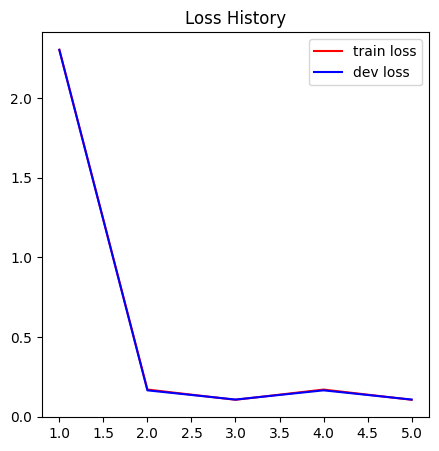

In [32]:
plt.plot([i + 1 for i in range(len(history))], [history[i][0] for i in range(len(history))], color='r', label='train loss')
plt.plot([i + 1 for i in range(len(history))], [history[i][1] for i in range(len(history))], color='b', label='dev loss')
plt.legend()
plt.title('Loss History')
plt.show()

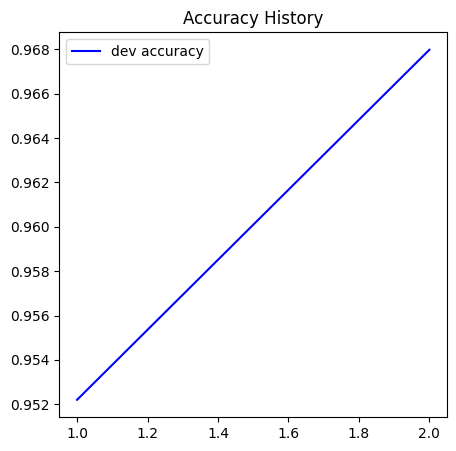

In [33]:
#plt.plot([i + 1 for i in range(len(acc_hist))], [acc_hist[i][0] for i in range(len(acc_hist))], color='r', label='train accuracy')
plt.plot([i + 1 for i in range(len(acc_hist))], [acc_hist[i][1] for i in range(len(acc_hist))], color='b', label='dev accuracy')
plt.legend()
plt.title('Accuracy History')
plt.show()

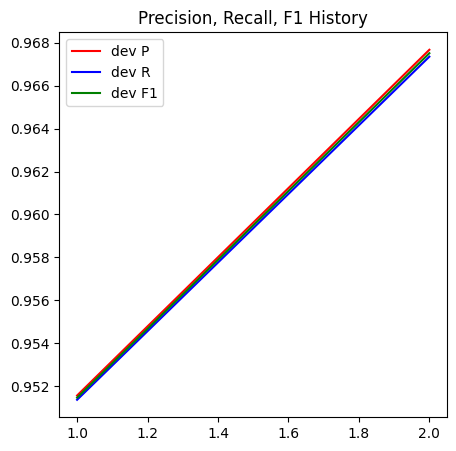

In [34]:
plt.plot([i + 1 for i in range(len(prf))], [prf[i][0] for i in range(len(prf))], color='r', label='dev P')
plt.plot([i + 1 for i in range(len(prf))], [prf[i][1] for i in range(len(prf))], color='b', label='dev R')
plt.plot([i + 1 for i in range(len(prf))], [prf[i][2] for i in range(len(prf))], color='g', label='dev F1')
plt.legend()
plt.title('Precision, Recall, F1 History')
plt.show()

In [35]:
print("-----Communication Overhead-----")

r_total = 0
for i in receive_list:
  r_total += i
print(f'Total Received Messages: {r_total} bytes')

s_total = 0
for i in send_list:
  s_total += i
print(f'Total Sent Messages: {s_total} bytes')

print(f'Total Communication Overhead: {r_total + s_total} bytes')

-----Communication Overhead-----
Total Received Messages: 3264 bytes
Total Sent Messages: 696 bytes
Total Communication Overhead: 3960 bytes


In [36]:
test_loss, test_acc, test_prec, test_rec, test_f1 = global_net.evaluate(test_dataset)
print('Final Test Evaluation, Loss = {}, Acc = {}, Prec = {}, Rec = {}, F1 = {}\n'.format(round(test_loss, 4),
             round(test_acc, 4), round(test_prec, 4), round(test_rec, 4), round(test_f1, 4)))

Final Test Evaluation, Loss = 0.0957, Acc = 0.9714, Prec = 0.9717, Rec = 0.9713, F1 = 0.9715

